# Final Project - Programming a Hopfield Network

Vuthy Vey <br>
COSC 16 <br>
November 15, 2023

In [477]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import arff

class HopfieldNetwork:
    def __init__(self, num_neurons):
        self.num_neurons = num_neurons
        self.weights = np.zeros((num_neurons, num_neurons))

    def train(self, patterns):
        for pattern in patterns:
            pattern = np.array(pattern)
            pattern = pattern.reshape((self.num_neurons, 1))
            self.weights += np.outer(pattern, pattern)
            np.fill_diagonal(self.weights, 0)

    def recall(self, pattern, max_iterations=100):
        pattern = np.array(pattern)
        pattern = pattern.reshape((self.num_neurons, 1))
        for _ in range(max_iterations):
            old_pattern = pattern.copy()
            pattern = np.sign(np.dot(self.weights, pattern))
            if np.array_equal(pattern, old_pattern): # Network converge to a stable state
                break
        return pattern
    

## Helper Functions

def int_to_binary_str(integer, num_bit):
    if integer < -2**(num_bit-1) or integer >= 2**(num_bit-1):
        raise ValueError("Integer out of range for " + str(num_bit) + "-bit representation")
    
    # Convert negative integer to its two's complement representation
    if integer < 0:
        integer = 2**num_bit + integer
    
    # Convert the integer to a binary string and remove the '0b' prefix
    binary_str = bin(integer)[2:]
    
    # Pad the binary string with leading zeros to make it num_bit bits long
    padded_binary_str = binary_str.zfill(num_bit)
    
    return padded_binary_str

def raw_to_bit(integer_list, num_bit):
    pattern_str = ""
    for integer in integer_list:
        pattern_str += int_to_binary_str(integer, num_bit)
        
    pattern = [1 if x == "1" else -1 for x in pattern_str] # convert bit strings to 1, and -1
    return pattern

def process(raw_data, num_bit=11):
    d = np.array(raw_data)
    d = d*180*np.tanh(d) # Apply Non-Linearity
    d = d.astype(int) # Round to an integer
    d = raw_to_bit(d, num_bit) # Convert to num_bit-bit binary representation
    return d

def get_vowel_class(vowel_dict, recovered_pattern):
    for key, pattern in vowel_dict.items():
        if np.array_equal(pattern, recovered_pattern):
            return key
    return "Not Found"

The network described is a bipolar Hopfield network, with vectors consisting of either 1 or -1. Its learning rule, defined in the train() function, employs the Hebbian rule to establish the weights of its neurons. The operational rule, implemented in the recall() function, sets a threshold of 0.

# Load Data

In [478]:
file_path = 'phpd8EoD9.arff'
data, meta = arff.loadarff(file_path)
dataframe = pd.DataFrame(data)
dataframe = dataframe.applymap(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)
print(meta)

Dataset: vowel-weka.filters.unsupervised.attribute.Remove-R1
	Speaker_Number's type is nominal, range is ('Andrew', 'Bill', 'David', 'Mark', 'Jo', 'Kate', 'Penny', 'Rose', 'Mike', 'Nick', 'Rich', 'Tim', 'Sarah', 'Sue', 'Wendy')
	Sex's type is nominal, range is ('Male', 'Female')
	Feature_0's type is numeric
	Feature_1's type is numeric
	Feature_2's type is numeric
	Feature_3's type is numeric
	Feature_4's type is numeric
	Feature_5's type is numeric
	Feature_6's type is numeric
	Feature_7's type is numeric
	Feature_8's type is numeric
	Feature_9's type is numeric
	Class's type is nominal, range is ('hid', 'hId', 'hEd', 'hAd', 'hYd', 'had', 'hOd', 'hod', 'hUd', 'hud', 'hed')



- The dataset was sourced from [OpenML](https://www.openml.org/search?type=data&sort=runs&id=307&status=active).
- It includes samples from 15 British English speakers.
- Each speaker pronounced each vowel six times.
- Vowels included are: 'hid', 'hId', 'hEd', 'hAd', 'hYd', 'had', 'hOd', 'hod', 'hUd', 'hud', and 'hed'.
- The vowels have been preprocessed into 10 numerical values, represented in columns Feature_0 through Feature_9.


In [479]:
dataframe.head()

,Speaker_Number,Sex,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Class
0,Andrew,Male,-3.639,0.418,-0.670,1.779,-0.168,1.627,-0.388,0.529,-0.874,-0.814,hid
1,Andrew,Male,-3.327,0.496,-0.694,1.365,-0.265,1.933,-0.363,0.510,-0.621,-0.488,hId
2,Andrew,Male,-2.120,0.894,-1.576,0.147,-0.707,1.559,-0.579,0.676,-0.809,-0.049,hEd
3,Andrew,Male,-2.287,1.809,-1.498,1.012,-1.053,1.060,-0.567,0.235,-0.091,-0.795,hAd
4,Andrew,Male,-2.598,1.938,-0.846,1.062,-1.633,0.764,0.394,-0.150,0.277,-0.396,hYd


# Build and Train the Network

The objective of constructing this network is to recognize patterns in numerical values representing different vowels in the dataset. The strategy involves training the network with a well-chosen input pattern, ideally leading to similar inputs converging to the same stable state. However, identifying the most suitable inputs for training is challenging, as the dataset varies in terms of speaker and sex. In the absence of a clear solution, we proceed with the assumption that any random input could serve as a suitable training pattern.
<br>
Prior to training, the dataset must be converted into a binary format, as the Hopfield network accepts only vector values of 1 and -1, whereas our raw data consists of decimal values roughly in the range of (-5.0, +5.0). The data preprocessing steps are as follows:

1. Introduce non-linearity; here, the tanh(x) function is used to enhance the distinction between different values.
2. Linearly amplify the data to expand its range.
3. Eliminate decimal points to obtain whole integers.
4.  Apply bit complement to negative values.
5. Convert integers into binary format (1, -1), with the bit number determined by the maximum possible value. Using a higher number of bits can degrade the input pattern's quality.

<br>
In the training phase, we randomly select an input from each vowel category in the dataset to train the network.

To evaluate accuracy, we loop through the dataset and run recall(vowel_pattern) to determine its stable state. A match between the stable state and the expected pattern indicates convergence. However, cases where the test input converges to a different vowel's stable state are noted, as these instances reduce the overall accuracy rate.

In [669]:
# vowel_str = ["hid", "hId", "hEd", "hAd", "hYd", "had", "hOd", "hod", "hUd", "hud", "hed"]
# speakers = ['Andrew', 'Bill', 'David', 'Mark', 'Jo', 'Kate', 'Penny', 'Rose', 'Mike', 'Nick', 'Rich', 'Tim', 'Sarah', 'Sue', 'Wendy']

# Change this to train on different classes
vowel_str = ["hAd","hUd"]
num_bit = 12 # number of neurons is num_bit * 10 features

df = dataframe.copy()
# df = df[df['Sex'] == 'Male']
# df = df[df['Speaker_Number'] == 'Jo']

Accuracy: 
hAd 0.9777777777777777
hUd 0.5


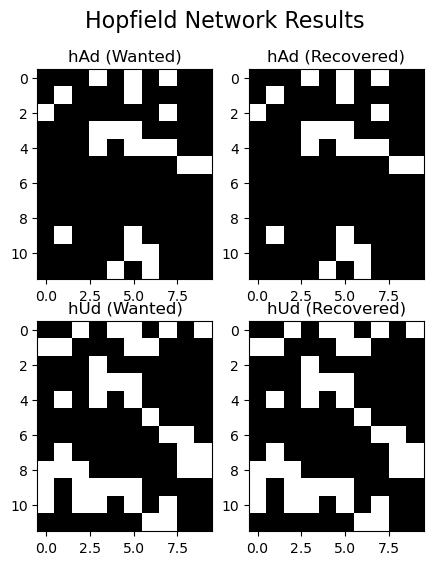

In [682]:

select = ['Feature_0', 'Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5', 'Feature_6', 'Feature_7', 'Feature_8', 'Feature_9']
vowel_dict = {}

# Filter and sample the data
for vowel_name in vowel_str:
    vowel_dict[vowel_name] = df[df['Class'] == vowel_name].sample()[select].values.tolist()[0]



# Process the data
for key, pattern in vowel_dict.items():
    d = process(pattern, num_bit)
    vowel_dict[key] = d

# Initialize the Hopfield Network
network = HopfieldNetwork(num_neurons=len(list(vowel_dict.values())[0]))

# Train the network
network.train(patterns=list(vowel_dict.values()))

# Recover the stable states
stable_states = {}
for key, pattern in vowel_dict.items():
    recovered_pattern = network.recall(pattern)
    stable_states[key] = recovered_pattern


# Plot the results
fig, axs = plt.subplots(nrows=len(vowel_dict.items()), ncols=2, figsize=(5, len(vowel_dict.items()) * 3))
fig.suptitle('Hopfield Network Results', fontsize=16)
for i, (key, pattern) in enumerate(vowel_dict.items()):
    # Plot the original pattern
    axs[i][0].imshow(np.array(pattern).reshape(num_bit, 10), cmap='gray')
    axs[i][0].set_title(key + " (Wanted)")
    
    # Plot the recovered pattern
    recovered_pattern = network.recall(pattern)
    axs[i][1].imshow(np.array(recovered_pattern).reshape(num_bit, 10), cmap='gray')
    axs[i][1].set_title(key + " (Recovered)")



# Test the network
select = ['Feature_0', 'Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5', 'Feature_6', 'Feature_7', 'Feature_8', 'Feature_9', 'Class']
df_test = df[select]

count = {}
total = {}
for vowel in vowel_str:
    count[vowel] = 0
    total[vowel] = 0

for i in range(len(df_test)):
    expect = str(df_test.iloc[i]['Class']) # Get the expected class e.g. "hid"
    if expect not in vowel_str:
        continue
    
    test_pattern = df_test.iloc[i].tolist()[:-1]

    test_pattern = process(test_pattern, num_bit)
    recovered_pattern = network.recall(test_pattern)

    if get_vowel_class(stable_states, recovered_pattern) == expect:
        count[expect] += 1
    total[expect] += 1

print("Accuracy: ")
for key, value in count.items():
    print(key, value/total[key])

# Results

<mark>Note: All training inputs were randomly selected from their corresponding filtered datasets.</mark>

**Test #1: Introduce all 11 vowels into the network (Full Dataset)**
- Result: Up to three stable states were observed, with one state often being more dominant.
- Typically, convergence occurred to only one stable state.

**Test #2: Introduce only long vowels: hAd, hEd, hId, hOd, hUd (Full Dataset)**   
- Results mirrored those of Test #1.

**Test #3: hAd, and hUd (Full Dataset)**
- Assumption: hAd and hUd have significantly different patterns, potentially leading to higher accuracy.
- Result: Two distinct stable states were observed, each with an accuracy rate reaching up to 85%.

**Test #4: hAd, hUd, hEd (Full Dataset)**
- Result: Three stable states emerged.
- Accuracy rate dropped to about 5% each states
- Most test inputs converged to different stable states than those used for training.
- Suggestion: The network has likely reached its capacity limit.
- Similar results were observed with other sets of three vowels.

**Test #5: hAd, and hUd (Sex Dataset)**
- Result: Slightly higher performance, with the highest accuracy rate for a stable state at 92% and the lowest at 35%.

**Test #6: hAd, and hUd (Individual Speaker Dataset)**
- Notable occurrences: 100% accuracy for both stable states with Speaker Jo.
- Overall, the network performed better with a focused group.
- This is not surprising, as the speaker's repetition of a vowel leads to closely linked patterns.


**Another test**
- Omitting the Non-Linearity component resulted in poorer accuracy rates.
- Increasing the number of neurons did not significantly affect the results, despite the increase in bit requirements for binary representation.
- Various Non-Linearity components were tested (e.g., sigmoid, exponential), but tanh was found to be the most effective.

**Future Proposal**

In considering future directions for this final project, several promising avenues present themselves. Firstly, the implementation of the Storkey learning rule, as opposed to the current Hebbian rule, could be a significant step forward. The Storkey learning rule has the potential to enhance the network's capacity, allowing for this complex pattern recognition. This could be particularly beneficial in situations where the current network reaches its capacity limit, as observed in some of the tests.

Additionally, the exploration of a continuous Hopfield network appears to be a worthwhile endeavor. Given that our raw data is primarily in decimal form, a continuous network might be more adept at processing and interpreting this type of data, potentially leading to improved accuracy and stability in the network's performance.

Lastly, a reevaluation of the network type seems prudent. Considering the nature of the data we are working with, which is predominantly numerical, branching out into other types of Artificial Neural Networks could yield more effective results. In particular, a backpropagation network might be more suitable for this kind of data processing and pattern recognition. Backpropagation networks are renowned for their efficiency in handling complex patterns and learning tasks, which could be exactly what is needed to overcome the limitations we've encountered with the current network model.





